# Benchmarking scripts for CytoSPACE

## Intallation of the running environment

* Install the envrioment of CytoSPACE based on the instructions: https://github.com/digitalcytometry/cytospace

In [2]:
import pandas as pd
import scanpy as sc
import os
from scipy.sparse import issparse
import logging
from scipy.spatial.distance import cdist
import seaborn as sns
import numpy as np
logging.getLogger().setLevel(logging.INFO)
import utils

## Utilized functions

In [4]:
def getResults(cur_query_data,cur_res):
    
    selected_ids = []
    predicted_coordinates = []
    truth_coordinates = []
    truth_cell_types = []
    
    truth_data = pd.DataFrame({'ID':cur_query_data.obs.index,\
                               "x":cur_query_data.obs['x'].values,\
                              "y":cur_query_data.obs['y'].values,\
                             'cell_type':cur_query_data.obs['cell_type'].values}).set_index("ID")

    for cur_cell_id in cur_query_data.obs_names:
        
        if(cur_cell_id not in cur_res.index):
            continue
            
        predicted_data = cur_res.loc[cur_cell_id]
        tmp_predicted_coor = [predicted_data['row'],predicted_data['col']]
        
        predicted_coordinates.append(tmp_predicted_coor)
        
        cur_truth_row =  truth_data.loc[cur_cell_id]
        tmp_truth_coor = [cur_truth_row['x'],cur_truth_row['y']]
        tmp_truth_cell_type = cur_truth_row['cell_type']
        
        truth_coordinates.append(tmp_truth_coor)
        truth_cell_types.append(tmp_truth_cell_type)
        
    
   
    predicted_coordinates = np.asarray(predicted_coordinates)
    truth_coordinates = np.asarray(truth_coordinates)
    
   
    return predicted_coordinates,truth_coordinates,truth_cell_types

## 1. Spatial reconstruction of mouse gastrulation cells using single-cell resolution ST reference

### 1.1 Performing alignment and evaluation
* Run in the terminal

#### 1.1.1 Alignment between embryo1 l1 and embryo1 l2

```
cytospace --single-cell --scRNA-path ./cytospace/embryo1_l2_test_geneExp.txt\
--st-path ./cytospace/embryo1_l1_train_geneExp.txt \
--coordinates-path ./cytospace/embryo1_l1_train_coordinates.txt  \
--st-cell-type-path ./cytospace/embryo1_l1_train_cellTypes.txt\
--cell-type-path ./cytospace/embryo1_l2_test_cellTypes.txt \
--number-of-processor 16 -noss 10000 \
-sm lap_CSPR -o cytospace/ -op embryo1_l2 -mcn 1
```

#### 1.1.2 Alignment between embryo1 l1 and embryo2 l2

```
cytospace --single-cell --scRNA-path ./cytospace/embryo2_l2_test_geneExp.txt\
--st-path ./cytospace/embryo1_l1_train_geneExp.txt \
--coordinates-path ./cytospace/embryo1_l1_train_coordinates.txt  \
--st-cell-type-path ./cytospace/embryo1_l1_train_cellTypes.txt\
--cell-type-path ./cytospace/embryo2_l2_test_cellTypes.txt \
--number-of-processor 16 -noss 10000 \
-sm lap_CSPR -o cytospace/ -op embryo2_l2 -mcn 1
```

#### 1.1.3 Alignment between embryo1 l1 and embryo3 l2

```
cytospace --single-cell --scRNA-path ./cytospace/embryo3_l2_test_geneExp.txt\
--st-path ./cytospace/embryo1_l1_train_geneExp.txt \
--coordinates-path ./cytospace/embryo1_l1_train_coordinates.txt  \
--st-cell-type-path ./cytospace/embryo1_l1_train_cellTypes.txt\
--cell-type-path ./cytospace/embryo3_l2_test_cellTypes.txt \
--number-of-processor 16 -noss 10000 \
-sm lap_CSPR -o cytospace/ -op embryo3_l2 -mcn 1
```

### 1.2. Performing evaluations


In [91]:
test_adata_list = {"embryo1_l2":embryo1_l2,"embryo2_l2":embryo2_l2,"embryo3_l2":embryo3_l2}

neighbor_hit_res = {'Dataset':[],'K nearest neighbor':[],'Average hit number':[]}
JSD_spearman_res = {'Dataset':[],'Average JSD':[],"Average spearman's rank correlation coefficient":[]}
res_summary_all   = {"Dataset":[],"Cell type":[],"Average JSD":[],"Average spearman":[]}

for test_name in test_adata_list:
    cur_test_adata = test_adata_list[test_name]
    
    logging.info("Evaluation for "+test_name)
    
    cur_result_path = os.path.join(SAVE_ROOT,test_name+"assigned_locations.csv")

    cur_result_data = pd.read_csv(cur_result_path).drop_duplicates(subset=['OriginalCID']).set_index("OriginalCID")
    predicted_coor,cur_truth_coor,cur_truth_cell_types = getResults(cur_test_adata,cur_result_data)
    
    predicted_distances =  cdist(predicted_coor, predicted_coor)
    predicted_sorted_ind = np.argsort(predicted_distances)
    
    truth_distances =  cdist(cur_truth_coor, cur_truth_coor)
    truth_sorted_ind = np.argsort(truth_distances)
    
    # neighbor hit
    cur_neighbor_res,cur_average_neighbor_res = utils.calNeiborHit(truth_sorted_ind,predicted_sorted_ind)
    neighbor_hit_res['Dataset'].extend([test_name]*10)
    neighbor_hit_res['K nearest neighbor'].extend(cur_average_neighbor_res['K nearest neighbor'])
    neighbor_hit_res['Average hit number'].extend(cur_average_neighbor_res['Average hit number'])
    
    # JSD
    cur_jsd_list = utils.calJSD(truth_sorted_ind,predicted_sorted_ind,cur_truth_cell_types,neighbor_num=20)
    
    # Spearman rank correlation
    spearman_corr_list,spearman_p_list = utils.calSpearmanRank(predicted_distances,truth_distances)
    
    JSD_spearman_res['Dataset'].append(test_name)
    JSD_spearman_res['Average JSD'].append(np.mean(cur_jsd_list))
    JSD_spearman_res["Average spearman's rank correlation coefficient"].append(np.mean(spearman_corr_list))
    
    res_summary_all['Dataset'].extend([test_name]*len(cur_truth_cell_types))
    res_summary_all['Cell type'].extend(cur_truth_cell_types)
    res_summary_all['Average JSD'].extend(cur_jsd_list)
    res_summary_all['Average spearman'].extend(spearman_corr_list)


neighbor_hit_res = pd.DataFrame(neighbor_hit_res)
JSD_spearman_res = pd.DataFrame(JSD_spearman_res)
res_summary_all = pd.DataFrame(res_summary_all)

INFO:root:Evaluation for embryo1_l2
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 7590/7590 [00:17<00:00, 425.93it/s]
INFO:root:Evaluation for embryo2_l2
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 5740/5740 [00:11<00:00, 516.65it/s]
INFO:root:Evaluation for embryo3_l2
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 7319/7319 [00:16<00:00, 430.79it/s]


In [94]:
res_summary_all.to_csv("results/cytospace_mouse_single_cell_ref.csv")

### 1.3 Benchmarking results

#### 1.3.1 Nearest neighbor hit

<Axes: xlabel='K nearest neighbor', ylabel='Average hit number'>

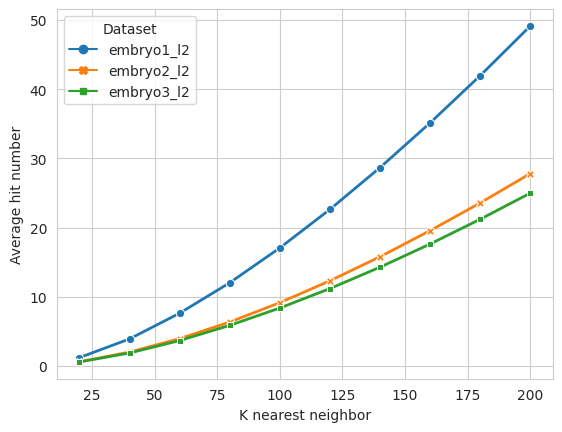

In [92]:
sns.set_style('whitegrid')
sns.lineplot(data=neighbor_hit_res,x="K nearest neighbor",y="Average hit number",hue="Dataset",markers=True,style='Dataset',\
             dashes=False,linewidth=2)

#### 1.3.2 Average JSD and spearman's rank correlation coefficient

In [93]:
display(JSD_spearman_res)

,Dataset,Average JSD,Average spearman's rank correlation coefficient
0,embryo1_l2,0.329119,0.606100
1,embryo2_l2,0.357342,0.318703
2,embryo3_l2,0.435005,0.292913


## 2. Spatial location inference across platforms: mouse gastrulation datasets

### 2.1 Performing alignment and evaluation

* Run in terminal


#### 2.1.1 Alignment between stereoseq sample and embryo1 l2

````
~/miniconda2/envs/cytospace/bin/cytospace --scRNA-path ./cytospace/embryo1_l2_stereoseq_test_geneExp.txt \
--cell-type-path ./cytospace/embryo1_l2_stereoseq_test_cellTypes.txt \
--st-path ./cytospace/stereoseq_train_geneExp.txt \
--coordinates-path ./cytospace/stereoseq_train_coordinates.txt \
-sm lap_CSPR --number-of-processor 16 -op stereoseq_embryo1_l2 -o ./cytospace
````

#### 2.1.2 Alignment between stereoseq sample and embryo2 l2

````
~/miniconda2/envs/cytospace/bin/cytospace --scRNA-path ./cytospace/embryo2_l2_stereoseq_test_geneExp.txt \
--cell-type-path ./cytospace/embryo2_l2_stereoseq_test_cellTypes.txt \
--st-path ./cytospace/stereoseq_train_geneExp.txt \
--coordinates-path ./cytospace/stereoseq_train_coordinates.txt \
-sm lap_CSPR --number-of-processor 16 -op stereoseq_embryo2_l2 -o ./cytospace
````

#### 2.1.3 Alignment between stereoseq sample and embryo3 l2


````
~/miniconda2/envs/cytospace/bin/cytospace --scRNA-path ./cytospace/embryo3_l2_stereoseq_test_geneExp.txt \
--cell-type-path ./cytospace/embryo3_l2_stereoseq_test_cellTypes.txt \
--st-path ./cytospace/stereoseq_train_geneExp.txt \
--coordinates-path ./cytospace/stereoseq_train_coordinates.txt \
-sm lap_CSPR --number-of-processor 16 -op stereoseq_embryo3_l2 -o ./cytospace
````

### 2.2 Performing evaluations


In [146]:

neighbor_hit_res = {'Dataset':[],'K nearest neighbor':[],'Average hit number':[]}
JSD_spearman_res = {'Dataset':[],'Average JSD':[],"Average spearman's rank correlation coefficient":[]}
res_summary_all   = {"Dataset":[],"Cell type":[],"Average JSD":[],"Average spearman":[]}

for test_name in test_adata_list:
    cur_test_adata = test_adata_list[test_name]
    
    logging.info("Evaluation for "+test_name)
    
    cur_result_path = os.path.join(SAVE_ROOT,"stereoseq_"+test_name+"assigned_locations.csv")

    cur_result_data = pd.read_csv(cur_result_path).drop_duplicates(subset=['OriginalCID']).set_index("OriginalCID")
    predicted_coor,cur_truth_coor,cur_truth_cell_types = getResults(cur_test_adata,cur_result_data)
    
    predicted_distances =  cdist(predicted_coor, predicted_coor)
    predicted_sorted_ind = np.argsort(predicted_distances)
    
    truth_distances =  cdist(cur_truth_coor, cur_truth_coor)
    truth_sorted_ind = np.argsort(truth_distances)
    
    # neighbor hit
    cur_neighbor_res,cur_average_neighbor_res = utils.calNeiborHit(truth_sorted_ind,predicted_sorted_ind)
    neighbor_hit_res['Dataset'].extend([test_name]*10)
    neighbor_hit_res['K nearest neighbor'].extend(cur_average_neighbor_res['K nearest neighbor'])
    neighbor_hit_res['Average hit number'].extend(cur_average_neighbor_res['Average hit number'])
    
    # JSD
    cur_jsd_list = utils.calJSD(truth_sorted_ind,predicted_sorted_ind,cur_truth_cell_types,neighbor_num=20)
    
    # Spearman rank correlation
    spearman_corr_list,spearman_p_list = utils.calSpearmanRank(predicted_distances,truth_distances)
    
    JSD_spearman_res['Dataset'].append(test_name)
    JSD_spearman_res['Average JSD'].append(np.mean(cur_jsd_list))
    JSD_spearman_res["Average spearman's rank correlation coefficient"].append(np.mean(spearman_corr_list))
    
    res_summary_all['Dataset'].extend([test_name]*len(cur_truth_cell_types))
    res_summary_all['Cell type'].extend(cur_truth_cell_types)
    res_summary_all['Average JSD'].extend(cur_jsd_list)
    res_summary_all['Average spearman'].extend(spearman_corr_list)
    

neighbor_hit_res = pd.DataFrame(neighbor_hit_res)
JSD_spearman_res = pd.DataFrame(JSD_spearman_res)
res_summary_all = pd.DataFrame(res_summary_all)

INFO:root:Evaluation for embryo1_l2
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 7656/7656 [00:16<00:00, 462.08it/s]
INFO:root:Evaluation for embryo2_l2
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 6521/6521 [00:12<00:00, 507.66it/s]
INFO:root:Evaluation for embryo3_l2
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 9401/9401 [00:23<00:00, 401.93it/s]


In [147]:
res_summary_all.to_csv("results/cytospace_mouse_stereoseq_ref.csv")

### 2.3. Benchmarking results


#### 2.3.1 Nearest neighbor hit

<Axes: xlabel='K nearest neighbor', ylabel='Average hit number'>

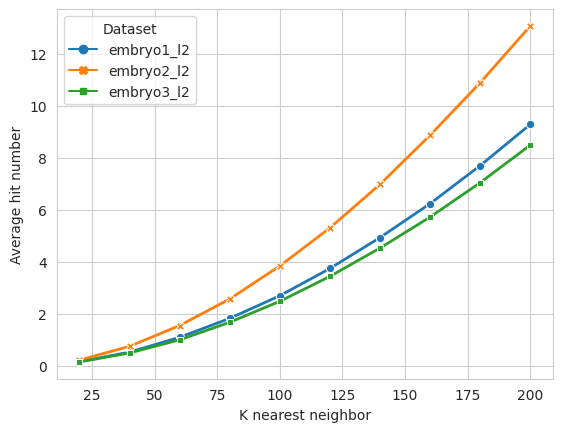

In [148]:
sns.set_style('whitegrid')
sns.lineplot(data=neighbor_hit_res,x="K nearest neighbor",y="Average hit number",hue="Dataset",markers=True,style='Dataset',\
             dashes=False,linewidth=2)

#### 2.3.2 Average JSD and spearman's rank correlation coefficient

In [149]:
display(JSD_spearman_res)

,Dataset,Average JSD,Average spearman's rank correlation coefficient
0,embryo1_l2,0.594813,0.077875
1,embryo2_l2,0.521585,0.138689
2,embryo3_l2,0.594941,0.087287


## 3. Spatial location inference across platforms: human breast cancer datasets

### 3.1 Performing alignment and evaluation


#### 3.1.1 Alignment between  human breast sample S06 and S08

````
cytospace --scRNA-path ./cytospace/human_breast_test_geneExp.txt \
--cell-type-path ./cytospace/human_breast_test_cellTypes.txt \
--st-path ./cytospace/human_breast_train_geneExp.txt  \
--coordinates-path ./cytospace/human_breast_train_coordinates.txt \
-sm lap_CSPR --number-of-processor 16 -op human_breast_cancer -o ./cytospace/
````

### 3.2 Performing evaluation

In [156]:
neighbor_hit_res = {'Dataset':[],'K nearest neighbor':[],'Average hit number':[]}
JSD_spearman_res = {'Dataset':[],'Average JSD':[],"Average spearman's rank correlation coefficient":[]}
res_summary_all   = {"Dataset":[],"Cell type":[],"Average JSD":[],"Average spearman":[]}

test_name = "10X visium S08"
cur_test_adata = adata_q
    
logging.info("Evaluation for "+test_name)
    
cur_result_path = os.path.join(SAVE_ROOT,"human_breast_cancerassigned_locations.csv")

cur_result_data = pd.read_csv(cur_result_path).drop_duplicates(subset=['OriginalCID']).set_index("OriginalCID")
predicted_coor,cur_truth_coor,cur_truth_cell_types = getResults(cur_test_adata,cur_result_data)
    
predicted_distances =  cdist(predicted_coor, predicted_coor)
predicted_sorted_ind = np.argsort(predicted_distances)
    
truth_distances =  cdist(cur_truth_coor, cur_truth_coor)
truth_sorted_ind = np.argsort(truth_distances)
    
# neighbor hit
cur_neighbor_res,cur_average_neighbor_res = utils.calNeiborHit(truth_sorted_ind,predicted_sorted_ind)
neighbor_hit_res['Dataset'].extend([test_name]*10)
neighbor_hit_res['K nearest neighbor'].extend(cur_average_neighbor_res['K nearest neighbor'])
neighbor_hit_res['Average hit number'].extend(cur_average_neighbor_res['Average hit number'])
    
# JSD
cur_jsd_list = utils.calJSD(truth_sorted_ind,predicted_sorted_ind,cur_truth_cell_types,neighbor_num=20)
    
# Spearman rank correlation
spearman_corr_list,spearman_p_list = utils.calSpearmanRank(predicted_distances,truth_distances)
    
JSD_spearman_res['Dataset'].append(test_name)
JSD_spearman_res['Average JSD'].append(np.mean(cur_jsd_list))
JSD_spearman_res["Average spearman's rank correlation coefficient"].append(np.mean(spearman_corr_list))
    
res_summary_all['Dataset'].extend([test_name]*len(cur_truth_cell_types))
res_summary_all['Cell type'].extend(cur_truth_cell_types)
res_summary_all['Average JSD'].extend(cur_jsd_list)
res_summary_all['Average spearman'].extend(spearman_corr_list)
    

neighbor_hit_res = pd.DataFrame(neighbor_hit_res)
JSD_spearman_res = pd.DataFrame(JSD_spearman_res)
res_summary_all = pd.DataFrame(res_summary_all)

INFO:root:Evaluation for 10X visium S08
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2801/2801 [00:03<00:00, 796.81it/s]


In [159]:
res_summary_all.to_csv("results/cytospace_human_breast.csv")

### 3.3 Benchmarking results


#### 3.3.1 Nearest neighbor hit

<Axes: xlabel='K nearest neighbor', ylabel='Average hit number'>

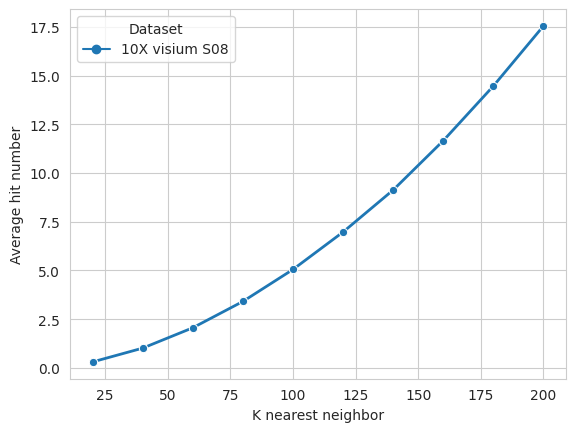

In [160]:
sns.set_style('whitegrid')
sns.lineplot(data=neighbor_hit_res,x="K nearest neighbor",y="Average hit number",hue="Dataset",markers=True,style='Dataset',\
             dashes=False,linewidth=2)

#### 3.3.2 Average JSD and spearman's rank correlation coefficient

In [161]:
display(JSD_spearman_res)

,Dataset,Average JSD,Average spearman's rank correlation coefficient
0,10X visium S08,0.430659,0.032598
